# CASE STUDY - topic modeling and feature engineering


[Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of using domain knowledge of your data to create features that can be leveraged by machine learning.  That is not a hard definition, because sometimes it is used in a context where features are transformed for machine learning, but the inclusion of domain knowledge is not implied.  

It is unfortunately common that for large datasets engineered features are not easy to create.  When there are many features generally only a small number play an important roll when it comes to prediction.  Furthermore,  domain insight is even more difficult to fold into the model when there are hundreds or thousands of features to keep in mind.  However, there is a middle ground---much of the worlds knowledge is locked up in language.  In this case study we will use topic modeling to gather insight from text.  Ideally, the result of these types of experiments would be shared with domain experts to further engineer features that are relevant when it comes to your business opportunity.

In [1]:
!pip install pyldavis

In [2]:
import os
import re
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from string import punctuation, printable
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

try:
    import pyLDAvis
    import pyLDAvis.sklearn
except:
    raise Exception("'pip install pyldavis' before running this notebook")

pyLDAvis.enable_notebook()    
plt.style.use('seaborn')
%matplotlib inline

## supress all warnings (not to be used during development)
import warnings
warnings.filterwarnings("ignore")

## Synopsis

   >Goal:  AAVAIL has recently enabled comments on the core streaming service.  The data science team knows that   this will be an incredibly important source of data going forward.  It will be used inform customer retention, product quality, product market fit and more.  Comments are going live next week and being the diligent data scientist that you are your plan is to build a topic modeling pipeline that that will consume the comments and create visualizations that can be used to communicate with domain experts.
  
## Outline

1. EDA - summary tables, use tSNE to visualize the data
2. Create a transfomation pipelines for NMF and LDA
3. Use ldaviz and wordclouds to get insight into the clusters

## Data

Here we see how to load the data.

* [download the movie review data](http://www.nltk.org/nltk_data)
* For more examples of applications with these data see [NLTK's book chapter that uses these data](https://www.nltk.org/book/ch06.html)

In [3]:
import nltk
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/dsxuser/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading p

True

In [4]:
movie_reviews = load_files("../nltk_data/corpora/movie_reviews", shuffle=True)
X = movie_reviews.data
y = movie_reviews.target
target_names = movie_reviews.target_names
print(len(X))
print(X[0])

2000
b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \nyes , the fil

### QUESTION 1

The main focus of this exercise is to enable visualization of topics, but these topics can be used as additional 
features for prediction tasks.  The goal of this case study is to ensure that you are comfortable with natural language processing pipelines and topic modeling tools. 

There are many ways to process tokens (words, dates, emojis etc).  NLTK is often used to pre-process text data before the tokens are vectorized.  Generally, the tokens are modified via [stemming or lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).  The next code block provides a lemmatization function that makes use of the library [spacy](https://spacy.io/).  You will need to install it and download the English language reference material as follows.  Stopwords are words that are very common or otherwise irrelevant we use a default list here, but it is an important part of NLP pipelines that needs to be customized for the subject area. Use the following function to process the corpus (this can take a few minutes)

```bash
~$ pip install spacy
~$ python -m spacy download en
```

If you prefer to use NLTK then you could use a simple lemmatizer like the WordLemmatizer.

In [5]:
!pip install spacy

In [6]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/envs/Python36/lib/python3.6/site-packages/en_core_web_sm -->
/opt/conda/envs/Python36/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [7]:
import spacy
STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo"])

if not 'nlp' in locals():
    print("Loading English Module...")
    nlp = spacy.load('en')

def lemmatize_document(doc, stop_words=None):
    """
    takes a list of strings where each string is a document
    returns a processed list of strings
    """
    
    if not stop_words:
        stop_words = set([])
  
    ## ensure working with string
    doc = str(doc)

    # First remove punctuation form string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)

    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
            
    # Run the doc through spaCy
    doc = nlp(clean_doc)

    # Lemmatize and lower text
    tokens = [re.sub("\W+","", token.lemma_.lower()) for token in doc ]
    tokens = [t for t in tokens if len(t) > 1]
    
    return ' '.join(w for w in tokens if w not in stop_words)    

## example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
print(corpus)
processed = [lemmatize_document(doc, STOPLIST) for doc in corpus]
print("\n" + processed[0])
processed = [lemmatize_document(doc, None) for doc in corpus]
print("\n" + processed[0])

Loading English Module...
['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']

pron fool people time people time pron fool people time abraham lincoln

pron can fool some of the people all of the time and all of the people some of the time but pron can not fool all of the people all of the time abraham lincoln


In [8]:
## Use stemming or lemmatization to process the corpus
processed = [lemmatize_document(doc, STOPLIST) for doc in X]
processed[0]

'barnold schwarzenegger icon action enthusiast late 80 lately pron film sloppy oneliner bad nit hard seeing arnold mr freeze batman robin especially pron say ton ice joke hey pron 15 million pron matter pron nonce arnold sign expensive blockbuster compare like terminator series true lie eraser nin dark thriller devil gabriel byrne come earth impregnate woman robin tunney happen 1000 year basically destroy world apparently god choose man man jericho cane arnold pron nwith help trusty sidekick kevin pollack pron stop let devil world npart actually absurd pron fit right dogma nye film weak pron blockbuster right sleepy hollow pron make world look like star film nanyway definitely like arnold movie nit just type film pron pron nsure pron pron chuckle pron know oneliner pron confused pron character film nit understandable especially ending change accord source naside form pron walk pron like pron past film nim sorry say arnold maybe end pron action day nspeake action pron film nthere hardly

In [9]:
from nltk.stem import WordNetLemmatizer
  
def my_lemmatize_document(doc, stop_words=None):
    """
    Use the WordNetLemmatizer from nltk package
    """
    
    # create an instant of WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    if not stop_words:
        stop_words = set([])
    
    # ensure working with string
    doc = str(doc)
    
    # First remove punctuation from string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)
        
    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
    
    tokens = [lemmatizer.lemmatize(w.lower()) for w in clean_doc.split(" ") if len(w)>1]
    
    return " ".join([token for token in tokens if token not in stop_words])
        
## example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
print(corpus)
my_processed = [my_lemmatize_document(doc, STOPLIST) for doc in corpus]
print("\n" + my_processed[0])
my_processed = [my_lemmatize_document(doc, None) for doc in corpus]
print("\n" + my_processed[0])

['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']

fool people time people time fool people time abraham lincoln

you can fool some of the people all of the time and all of the people some of the time but you can not fool all of the people all of the time abraham lincoln


In [10]:
my_processed = [my_lemmatize_document(doc, STOPLIST) for doc in X]
my_processed[0]

'barnold schwarzenegger ha icon action enthusiast late 80 lately film sloppy oneliners getting worse nit hard seeing arnold mr freeze batman robin especially say ton ice joke hey got 15 million whats matter nonce arnold ha signed expensive blockbuster compare like terminator series true lie eraser nin called dark thriller devil gabriel byrne ha come earth impregnate woman robin tunney happens 1000 year basically destroy world apparently god ha chosen man man jericho cane arnold nwith help trusty sidekick kevin pollack stop let devil world nparts actually absurd fit right dogma nyes film weak better blockbuster right sleepy hollow make world look like star film nanyway definitely doesnt like arnold movie nit just wasnt type film doing nsure gave u chuckle known oneliners confused character film wa going nit understandable especially ending changed according source naside form walked like ha past film nim sorry say arnold maybe end action day nspeaking action wa film nthere wa hardly exp

In [11]:
print(X[0])
print("\n" + processed[0])
print("\n" + my_processed[0])

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . \nwith the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! \nparts of this are actually so absurd , that they would fit right in with dogma . \nyes , the film is 

### QUESTION 2

Use the CountVectorizer from sklearn to vectorize the tokens.

Additional resources:

* [scikit-learn CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [scikit-learn working with text](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

Because this is an exercise in visualization set the `max_features` to something like 1000.  In the context of supervised learning it is reasonable to grid-search to optimize this parameter.

In [12]:
max_features = 1000
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=max_features, stop_words='english')

X_counts = count_vectorizer.fit_transform(processed)

print(X_counts.shape)
print(count_vectorizer.get_feature_names()[:10])
print(X_counts.toarray()[:5])

(2000, 1000)
['10', '90', 'ability', 'able', 'absolutely', 'accent', 'accept', 'accident', 'act', 'acting']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


**From occurrences to frequencies**

Occurrence count is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics. To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called `tf` for Term Frequencies.

Another refinement on top of `tf` is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus. This downscaling is called `tf–idf` for “Term Frequency times Inverse Document Frequency”.

Both `tf` and `tf–idf` can be computed as follows using `TfidfTransformer`

In [13]:
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print(X_tfidf.shape)
print(X_tfidf.toarray()[:5])

(2000, 1000)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.07455774]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [14]:
max_features = 1000
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=max_features, stop_words='english')

tfidf_transformer = TfidfTransformer()

preprocess_pipeline = Pipeline([('counter', count_vectorizer),
                                ('tfidf', tfidf_transformer)])

X_final = preprocess_pipeline.fit_transform(processed)
print(X_final.shape)
print(X_final.toarray()[:5])

(2000, 1000)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.07455774]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


### QUESTION 3

Use model the corpus with LDA.  For example, you could use something like the following.

```python
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

lda_model.fit(tf)
```

You could use a pipeline here to make it easier to iterate on changes.

* [scikit-learn's LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
* [scikit-learn's user guide for LDA](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

In [15]:
max_features = 1000
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=max_features, stop_words='english')

n_topics = 30
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0)

model_pipeline = Pipeline([('counter', count_vectorizer),
                           #('tfidf', tfidf_transformer), 
                           ('lda', lda_model)])

model_pipeline.fit(processed)

print(model_pipeline.named_steps["lda"])

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=30, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [16]:
X_lda = model_pipeline.transform(processed)
print(X_lda.shape)
print(X_lda[:3])

(2000, 30)
[[2.04498978e-04 2.04498978e-04 2.04498978e-04 2.04498978e-04
  2.04498978e-04 2.04498978e-04 2.04498978e-04 3.38775104e-01
  6.55498924e-01 2.04498978e-04 2.04498978e-04 2.04498978e-04
  2.04498978e-04 2.04498978e-04 2.04498978e-04 2.04498978e-04
  2.04498978e-04 2.04498978e-04 2.04498978e-04 2.04498978e-04
  2.04498978e-04 2.04498978e-04 2.04498978e-04 2.04498978e-04
  2.04498978e-04 2.04498978e-04 2.04498978e-04 2.04498978e-04
  2.04498978e-04 2.04498978e-04]
 [1.30679723e-01 2.02020202e-04 2.02020202e-04 2.02020202e-04
  2.02020202e-04 2.02020202e-04 2.02020202e-04 2.02020202e-04
  4.19004557e-01 2.02020202e-04 2.02020202e-04 1.83829530e-01
  2.02020202e-04 2.02020202e-04 2.02020202e-04 2.02020202e-04
  2.02020202e-04 2.02020202e-04 2.02020202e-04 2.02020202e-04
  2.02020202e-04 2.02020202e-04 2.02020202e-04 2.02020202e-04
  2.02020202e-04 2.02020202e-04 2.02020202e-04 2.02020202e-04
  2.61233665e-01 2.02020202e-04]
 [3.96825397e-04 3.96825397e-04 3.96825397e-04 3.968253

## QUESTION 4

Visualize the corpus using [pyldavis](https://github.com/bmabey/pyLDAvis).

```python
pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)
```

* [PyLDAViz documentation](https://pyldavis.readthedocs.io/en/latest)
* [PyLDAViz demos](https://pyldavis.readthedocs.io/en/latest/readme.html#video-demos)

In [17]:
X_count = model_pipeline.named_steps["counter"].transform(processed)

pyLDAvis.sklearn.prepare(model_pipeline.named_steps["lda"], X_count, model_pipeline.named_steps["counter"], R=20)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.038424  0.030784       1        1  27.132872
7     -0.041482  0.032572       2        1  26.620364
11    -0.031120 -0.000599       3        1  14.728496
28    -0.054247  0.041130       4        1  12.139482
18    -0.091209  0.036278       5        1  10.986898
14    -0.069744  0.001491       6        1   2.060696
17    -0.060722  0.047711       7        1   1.953649
5     -0.072418  0.046013       8        1   1.187813
0     -0.019966  0.063210       9        1   0.983667
3      0.259555 -0.118632      10        1   0.594061
10     0.262685  0.234809      11        1   0.305180
21     0.115121 -0.007574      12        1   0.279546
9      0.120958  0.145039      13        1   0.177369
4     -0.044334 -0.013830      14        1   0.158978
26     0.135007 -0.269127      15        1   0.157772
19     0.017449 -0.081027      16        1   0.152908
15    -0.056282 -0.019868      17        1   0.064671
16    -0.031949 -0.018853      18        1   0.057851
20    -0.007793 -0.027923      19        1   0.057680
1     -0.025032 -0.001262      20        1   0.018186
25    -0.025889 -0.007428      21        1   0.018186
2     -0.023306 -0.002077      22        1   0.018186
29    -0.025765 -0.009991      23        1   0.018186
23    -0.026438 -0.008659      24        1   0.018186
13    -0.028176 -0.012657      25        1   0.018186
27    -0.028666 -0.015764      26        1   0.018186
24    -0.026915 -0.016093      27        1   0.018186
12    -0.027402 -0.017243      28        1   0.018186
6     -0.027382 -0.015208      29        1   0.018186
22    -0.026111 -0.015220      30        1   0.018186, topic_info=    Category          Freq        Term         Total  loglift  logprob
321  Default  10773.000000        film  10773.000000  20.0000  20.0000
603  Default   7745.000000        nthe   7745.000000  19.0000  19.0000
537  Default   6748.000000       movie   6748.000000  18.0000  18.0000
474  Default   1660.000000        life   1660.000000  17.0000  17.0000
493  Default   4062.000000        make   4062.000000  16.0000  16.0000
850  Default   2300.000000       story   2300.000000  15.0000  15.0000
476  Default   3635.000000        like   3635.000000  14.0000  14.0000
838  Default   1220.000000        star   1220.000000  13.0000  13.0000
357  Default   3330.000000        good   3330.000000  12.0000  12.0000
137  Default   3809.000000   character   3809.000000  11.0000  11.0000
667  Default   1464.000000        plot   1464.000000  10.0000  10.0000
764  Default   2576.000000       scene   2576.000000   9.0000   9.0000
910  Default   2779.000000        time   2779.000000   8.0000   8.0000
571  Default   1857.000000          ni   1857.000000   7.0000   7.0000
990  Default   1027.000000       world   1027.000000   6.0000   6.0000
495  Default   1814.000000         man   1814.000000   5.0000   5.0000
664  Default   2256.000000        play   2256.000000   4.0000   4.0000
445  Default   2736.000000        just   2736.000000   3.0000   3.0000
555  Default   1800.000000        nbut   1800.000000   2.0000   2.0000
487  Default   1321.000000        love   1321.000000   1.0000   1.0000
69    Topic1    149.333716      batman    180.923396   1.1125  -6.4946
982   Topic1     89.696011       witch    110.074742   1.0997  -7.0043
747   Topic1    137.779858       robin    171.945189   1.0829  -6.5751
776   Topic1     81.698972        sean    109.810592   1.0087  -7.0977
406   Topic1    104.606762        hunt    144.952467   0.9782  -6.8505
987   Topic1     81.099186        wood    114.673020   0.9580  -7.1051
979   Topic1     80.180961      willis    117.874739   0.9191  -7.1165
909   Topic1     88.851213         tim    130.934266   0.9167  -7.0138
101   Topic1    109.270435   brilliant    168.766510   0.8697  -6.8069
85    Topic1    316.003126       black    488.404602   0.8690  -5.7450
..       ...           ...  

## QUESTION 5

Try different numbers of clusters until there is decent separation in the visualization

In [18]:
model_pipeline.set_params(lda__n_components=10)

model_pipeline.fit(processed)
print(model_pipeline.named_steps["lda"])

X_lda = model_pipeline.transform(processed)
print(X_lda.shape)

X_count = model_pipeline.named_steps["counter"].transform(processed)

pyLDAvis.sklearn.prepare(model_pipeline.named_steps["lda"], X_count, model_pipeline.named_steps["counter"], R=20)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
(2000, 10)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.003008 -0.005134       1        1  38.006099
8     -0.020065 -0.031353       2        1  35.121996
1     -0.005264 -0.034874       3        1  10.571538
5     -0.032837 -0.065788       4        1   6.595433
4     -0.024275 -0.100184       5        1   4.071189
0     -0.009535 -0.047388       6        1   3.930127
2     -0.122270  0.254781       7        1   0.699978
3      0.299756  0.076939       8        1   0.553726
9     -0.068372 -0.028629       9        1   0.395355
6     -0.014129 -0.018372      10        1   0.054558, topic_info=    Category          Freq          Term         Total  loglift  logprob
321  Default  10959.000000          film  10959.000000  20.0000  20.0000
603  Default   7796.000000          nthe   7796.000000  19.0000  19.0000
838  Default   1209.000000          star   1209.000000  18.0000  18.0000
537  Default   6628.000000         movie   6628.000000  17.0000  17.0000
10   Default   1146.000000        action   1146.000000  16.0000  16.0000
493  Default   4073.000000          make   4073.000000  15.0000  15.0000
786  Default    572.000000        series    572.000000  14.0000  14.0000
764  Default   2580.000000         scene   2580.000000  13.0000  13.0000
474  Default   1679.000000          life   1679.000000  12.0000  12.0000
850  Default   2333.000000         story   2333.000000  11.0000  11.0000
476  Default   3598.000000          like   3598.000000  10.0000  10.0000
137  Default   3809.000000     character   3809.000000   9.0000   9.0000
368  Default    870.000000           guy    870.000000   8.0000   8.0000
357  Default   3323.000000          good   3323.000000   7.0000   7.0000
319  Default    469.000000         fight    469.000000   6.0000   6.0000
449  Default    692.000000          kill    692.000000   5.0000   5.0000
664  Default   2254.000000          play   2254.000000   4.0000   4.0000
126  Default    828.000000          cast    828.000000   3.0000   3.0000
25   Default    564.000000         alien    564.000000   2.0000   2.0000
910  Default   2778.000000          time   2778.000000   1.0000   1.0000
356   Topic1    117.746659      godzilla    119.960946   0.9488  -7.0692
500   Topic1    130.307834          mars    134.589967   0.9351  -6.9678
862   Topic1    222.164025        stupid    245.449640   0.8677  -6.4343
254   Topic1    157.178187          dumb    175.377114   0.8579  -6.7804
112   Topic1    155.023934         bunch    173.329624   0.8558  -6.7942
25    Topic1    497.724706         alien    564.430722   0.8417  -5.6277
442   Topic1    333.534281          joke    379.416603   0.8385  -6.0280
346   Topic1    140.196831           gag    159.843864   0.8363  -6.8947
614   Topic1    208.700530         nwell    250.223031   0.7860  -6.4968
618   Topic1    147.343422          nwhy    177.036182   0.7838  -6.8450
..       ...           ...           ...           ...      ...      ...
346  Topic10      0.239887           gag    159.843864   1.0119  -6.7191
810  Topic10      0.223355      slightly    145.708909   1.0331  -6.7905
252  Topic10      0.293147          drug    234.992506   0.8270  -6.5186
879  Topic10      0.232854  surprisingly    165.027926   0.9502  -6.7489
352  Topic10      0.241945         giant    182.195193   0.8895  -6.7106
209  Topic10      0.370982         death    476.717201   0.3551  -6.2831
646  Topic10      0.249183          paul    196.336220   0.8443  -6.6811
46   Topic10      0.250802      approach    199.598769   0.8343  -6.6746
783  Topic10      0.379066         sense    598.183179   0.1497  -6.2616
570  Topic10      0.346490      nhowever    517.800563   0.2042  -6.3514
936  Topic10      0.257983         twist    245.670553   0.6548  -6.6464
632  Topic10      0.279901         order    344.175089   0.3992  -6.5648
537  Topic10      0.612023         movie   6628.305143  -1.7764  -5.7825
662  Topic10      0.2661

The visualization here can help determine a reasonable number of number of clusters and it can serve as a communication tool.  If the goal was to find topics that are associated with customer profiles then you would likely work with folks in marketing to refine the clustering.  There are a couple of parameters than can be used to modify the clustering and visualization.  The discovery of meaningful topics is a form of feature engineering.

## QUESTION 6

If you were to use the topics from this model to inform clustering or supervised learning you would first need to be able to extract and represent them as a matrix.  Along the same lines if you were to populate a report with tabular descriptions of the data then you will need to be able to extract topic representations.  Here is a starter function

```python
def get_top_words(model, feature_names, n_top_words):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return(top_words)
```

Use the function to print the top k words for each topic

In [19]:
def get_top_words(model, feature_names, n_top_words):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return(top_words)

n_top_words = 10
feature_names = model_pipeline.named_steps["counter"].get_feature_names()

top_words = get_top_words(model_pipeline.named_steps["lda"] , feature_names, n_top_words)

for key,vals in top_words.items():
    print("topic {}:".format(key), " ".join(vals))

topic 0: film nthe horror scream killer movie character world murder make
topic 1: film nthe war story make character nit time man disney
topic 2: jackie chan carter toy fight art master action mr lee
topic 3: star trek series generation television fan film episode planet crew
topic 4: nthe life film town story family truman father harry mother
topic 5: nthe film school high love play sex friend make movie
topic 6: film movie nthe like nbut sense death end scene character
topic 7: movie film nthe like make good just bad nit ni
topic 8: film nthe character make movie good like scene nit play
topic 9: vampire comic book batman film blood kiss nthe kill robin


## QUESTION (EXTRA CREDIT) 7

If you used `fit_transform` on your original tokens you should have a `2000 x k` array where `k` is the number of topics you choose.  Create a PCA or tSNE visualization that projects the tf matrix into lower dimensional space then uses colors to indicate which documents belong to a topic (e.g. probability > 0.5).

In [20]:
X_count = model_pipeline.named_steps["counter"].transform(processed).todense()
print(X_count.shape)

X_lda = model_pipeline.transform(processed)
print(X_lda.shape)

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X_count)
print(X_reduced.shape)

y = np.argmax(X_lda, axis=1)
print(y.shape)

(2000, 1000)
(2000, 10)
(2000, 2)
(2000,)


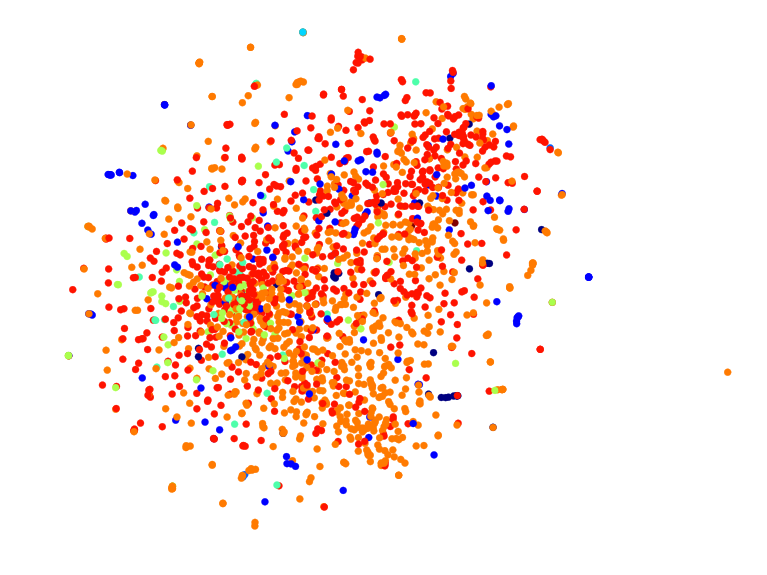

In [21]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.show()

In [24]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib as mpl

def plot_topics(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the topics plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    
    neighbors = np.array([[10., 10.]])
    
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    topics = np.unique(y)
    
    for topic in topics:
        plt.scatter(X_normalized[y == topic, 0], X_normalized[y == topic, 1], c=[cmap(topic / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

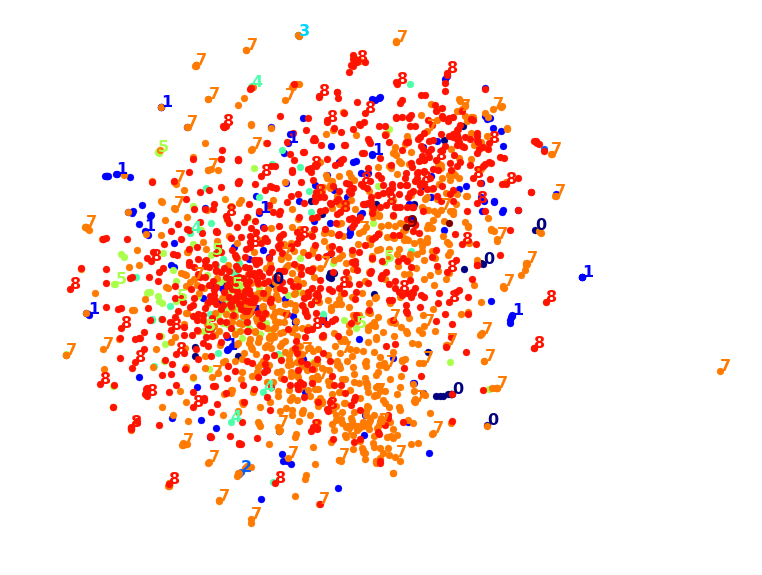

In [25]:
plot_topics(X_reduced, y)